In [1]:
import psutil
import GPUtil

# Get CPU information
cpu_count = psutil.cpu_count(logical=True)
cpu_percent = psutil.cpu_percent(interval=1)

# Get Memory information
memory_info = psutil.virtual_memory()

# Get GPU information
gpus = GPUtil.getGPUs()

# Format GPU information
gpu_info = ""
for gpu in gpus:
    gpu_info += f"""
    GPU ID: {gpu.id}
    Name: {gpu.name}
    Total Memory: {gpu.memoryTotal} MB
    Available Memory: {gpu.memoryFree} MB
    Used Memory: {gpu.memoryUsed} MB
    GPU Load: {gpu.load * 100:.1f}%
    Temperature: {gpu.temperature} °C
    """

# Format the output
formatted_output = f"""
System Information:
--------------------
CPU:
- Total CPUs: {cpu_count}
- CPU Usage: {cpu_percent}%

Memory:
- Total Memory: {memory_info.total / (1024 ** 3):.2f} GB
- Available Memory: {memory_info.available / (1024 ** 3):.2f} GB
- Used Memory: {memory_info.used / (1024 ** 3):.2f} GB
- Memory Usage: {memory_info.percent}%

GPU:
{gpu_info}
"""

print(formatted_output)


System Information:
--------------------
CPU:
- Total CPUs: 24
- CPU Usage: 12.7%

Memory:
- Total Memory: 125.79 GB
- Available Memory: 113.43 GB
- Used Memory: 8.35 GB
- Memory Usage: 9.8%

GPU:

    GPU ID: 0
    Name: Tesla P100-PCIE-12GB
    Total Memory: 12288.0 MB
    Available Memory: 12184.0 MB
    Used Memory: 2.0 MB
    GPU Load: 0.0%
    Temperature: 30.0 °C
    



In [2]:
import os
import sys
sys.path.append(os.getcwd())

from tumorpde.models._base import TumorVarFieldBase
from tumorpde.models.deform import TumorDeformFD
from tumorpde.volume_domain import VolumeDomain

import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.set_default_device(device)
print(f"The current device is: {device}")

from datetime import datetime
import pandas as pd

from expriment_helpers import read_patient_data, weighted_center
from expriment_helpers import _vis_brain_scan

import matplotlib.pyplot as plt

The current device is: cuda


In [147]:
import importlib
import sys
importlib.reload(sys.modules["tumorpde.models._base"])
importlib.reload(sys.modules["tumorpde.models.deform"])

<module 'tumorpde.models.deform' from '/scratch/muye/TumorPDE/tumorpde/models/deform.py'>

In [280]:
patient = "WANG-WAN-DA"
indexes = [2,3]
ref_scan = 2

In [281]:
data = read_patient_data(patient, test=False, mask_ids=indexes, ref=ref_scan)

Read data:
Patient brain, shape: (193, 229, 193)
Patient raw scan, shape: (193, 229, 193)
Grey matter, shape: (193, 229, 193)
White matter, shape: (193, 229, 193)
Tumor mask 1, shape: (193, 229, 193)
Tumor mask 2, shape: (193, 229, 193)


In [282]:
data_path = data["dir_path"]
brain_raw = data["t1"]
gm = data["gm"]
wm = data["wm"]
csf_in = data["csf_in"]
csf_out = data["csf_out"]
tumor_list = data["tumor"]
aff_info = data["aff_info"]
header = data["header"]
del data

In [283]:
# downsize the images: for testing
import numpy as np
from scipy.ndimage import zoom

def zoom_3d_array(data, zoom_factor):
    if isinstance(zoom_factor, (tuple, list)):
        zx, zy, zz = zoom_factor
    else:
        zx = zy = zz = zoom_factor

    zoom_factors = tuple([zx, zy, zz])
    
    data = zoom(data, zoom_factors, order=1)
    
    return data

zoom_factor = 0.7
brain_raw = zoom_3d_array(brain_raw, zoom_factor)
gm = zoom_3d_array(gm, zoom_factor)
wm = zoom_3d_array(wm, zoom_factor)
csf_in = zoom_3d_array(csf_in, zoom_factor)
csf_out = zoom_3d_array(csf_out, zoom_factor)
tumor_list = [zoom_3d_array(tumor, zoom_factor) for tumor in tumor_list]


In [284]:
matters = torch.cat([
    torch.tensor(gm, device=device).unsqueeze(0),
    torch.tensor(wm, device=device).unsqueeze(0),
    torch.tensor(csf_in, device=device).unsqueeze(0)
], dim=0)

In [285]:
geom = VolumeDomain((gm + wm + csf_in), [1.,1.,1.])

# Define the time domain
t0, t1 = 0., 1.

In [286]:
alpha = 100.
D = 1.
M = 1.
kappa = 10.
D_ratio = 0.02
kappa_ratios = [0.1, 0.5]
cx = weighted_center(tumor_list[0]) + 0.5  # initialized the center
init_peak_height = 0.01
init_peak_width = 2
init_density_params  = {"w": init_peak_width, "h": init_peak_height, "rmax": 4.}
# init_tumor_density = torch.as_tensor(tumor_list[0], device=device)
# def init_density_func(x, params = None | torch.Tensor, rmax = 0.1):
#     return rmax * init_tumor_density

# init_density_params = {"rmax": 0.3}

In [287]:
# create the PDE model
pde = TumorDeformFD(geom, matters,
                    D, alpha, M, kappa,
                    D_ratio, kappa_ratios,
                    init_learnable_params=cx,
                    init_other_params=init_density_params,
                    device=device)
# pde = TumorDeformFD(geom, matters,
#                     D, alpha, M, kappa,
#                     D_ratio, kappa_ratios,
#                     init_density_func=init_density_func,
#                     init_other_params=init_density_params,
#                     device=device)

In [288]:
dt = 0.001
state, t = pde.solve(None, dt, t1 = 0.1)

In [292]:
state, t = pde.solve(state, dt, t1 = 0.5)

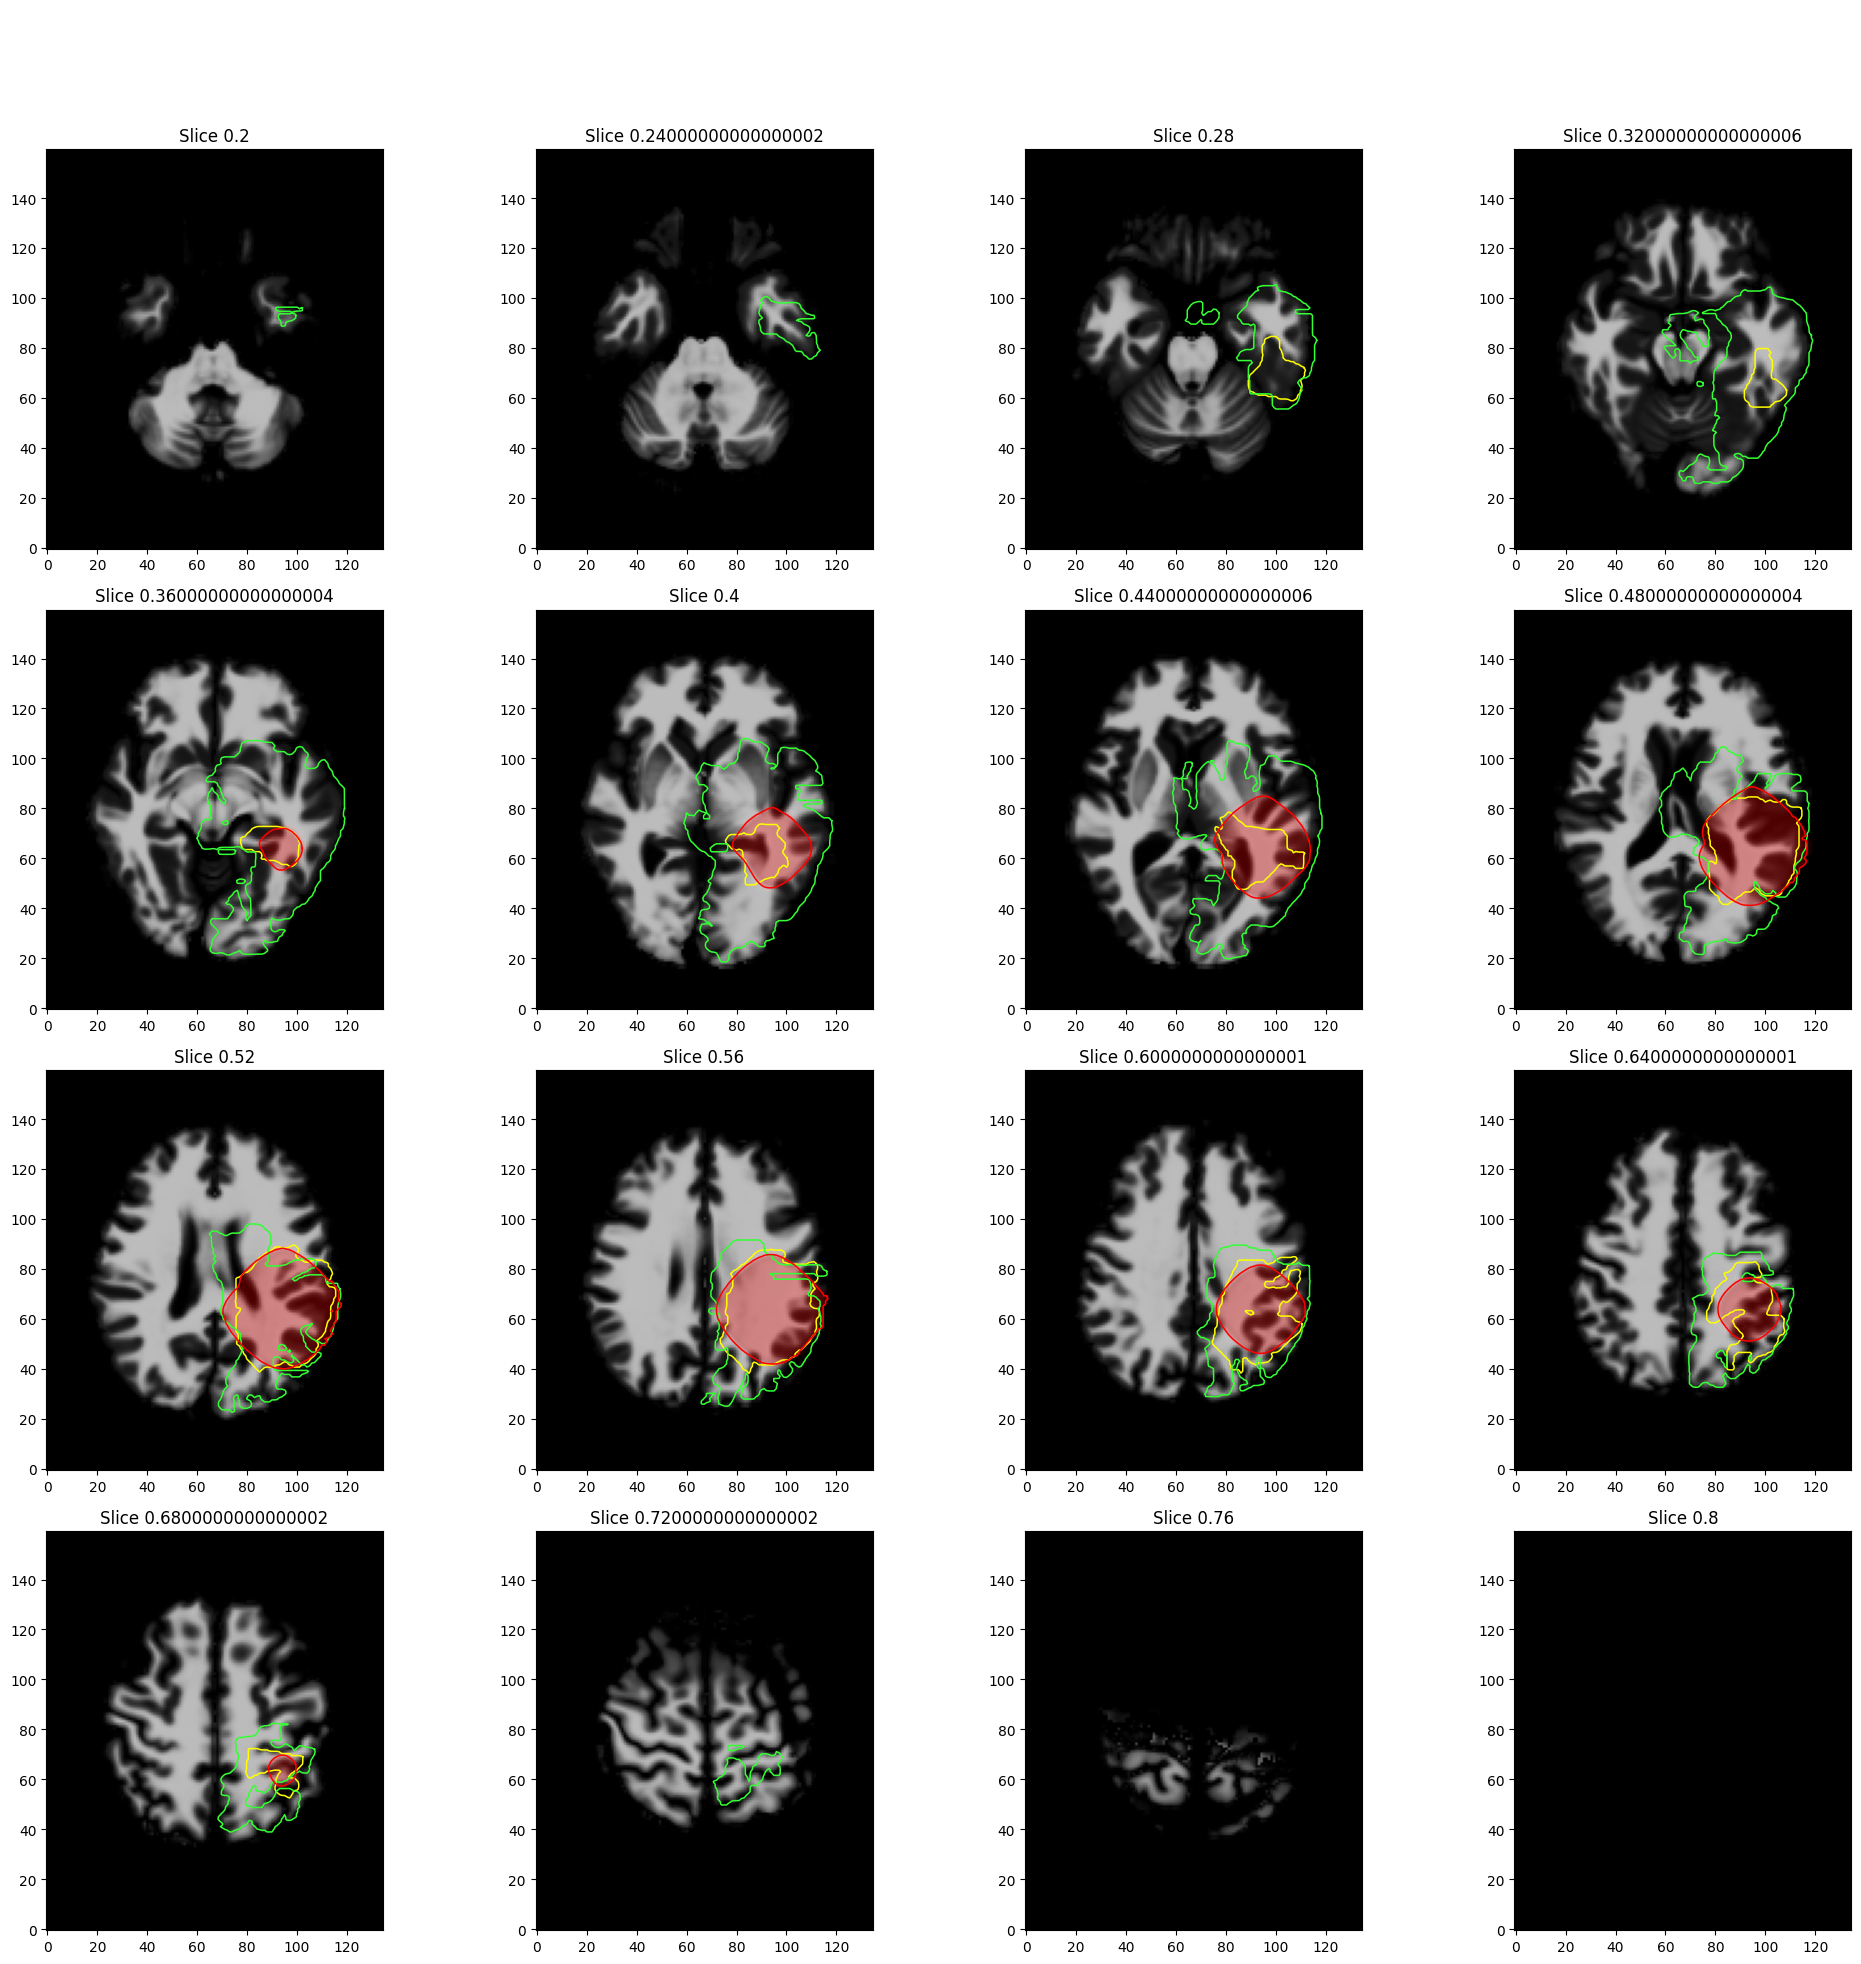

In [293]:
tmp_brain = 0.1 * state.brain_density[0].detach().cpu().numpy() + \
    0.9 * state.brain_density[1].detach().cpu().numpy()
_vis_brain_scan(state.tumor_density.detach().cpu().numpy(),
                [tmp_brain], tumor_list, figsize=(5,5), main_title="")

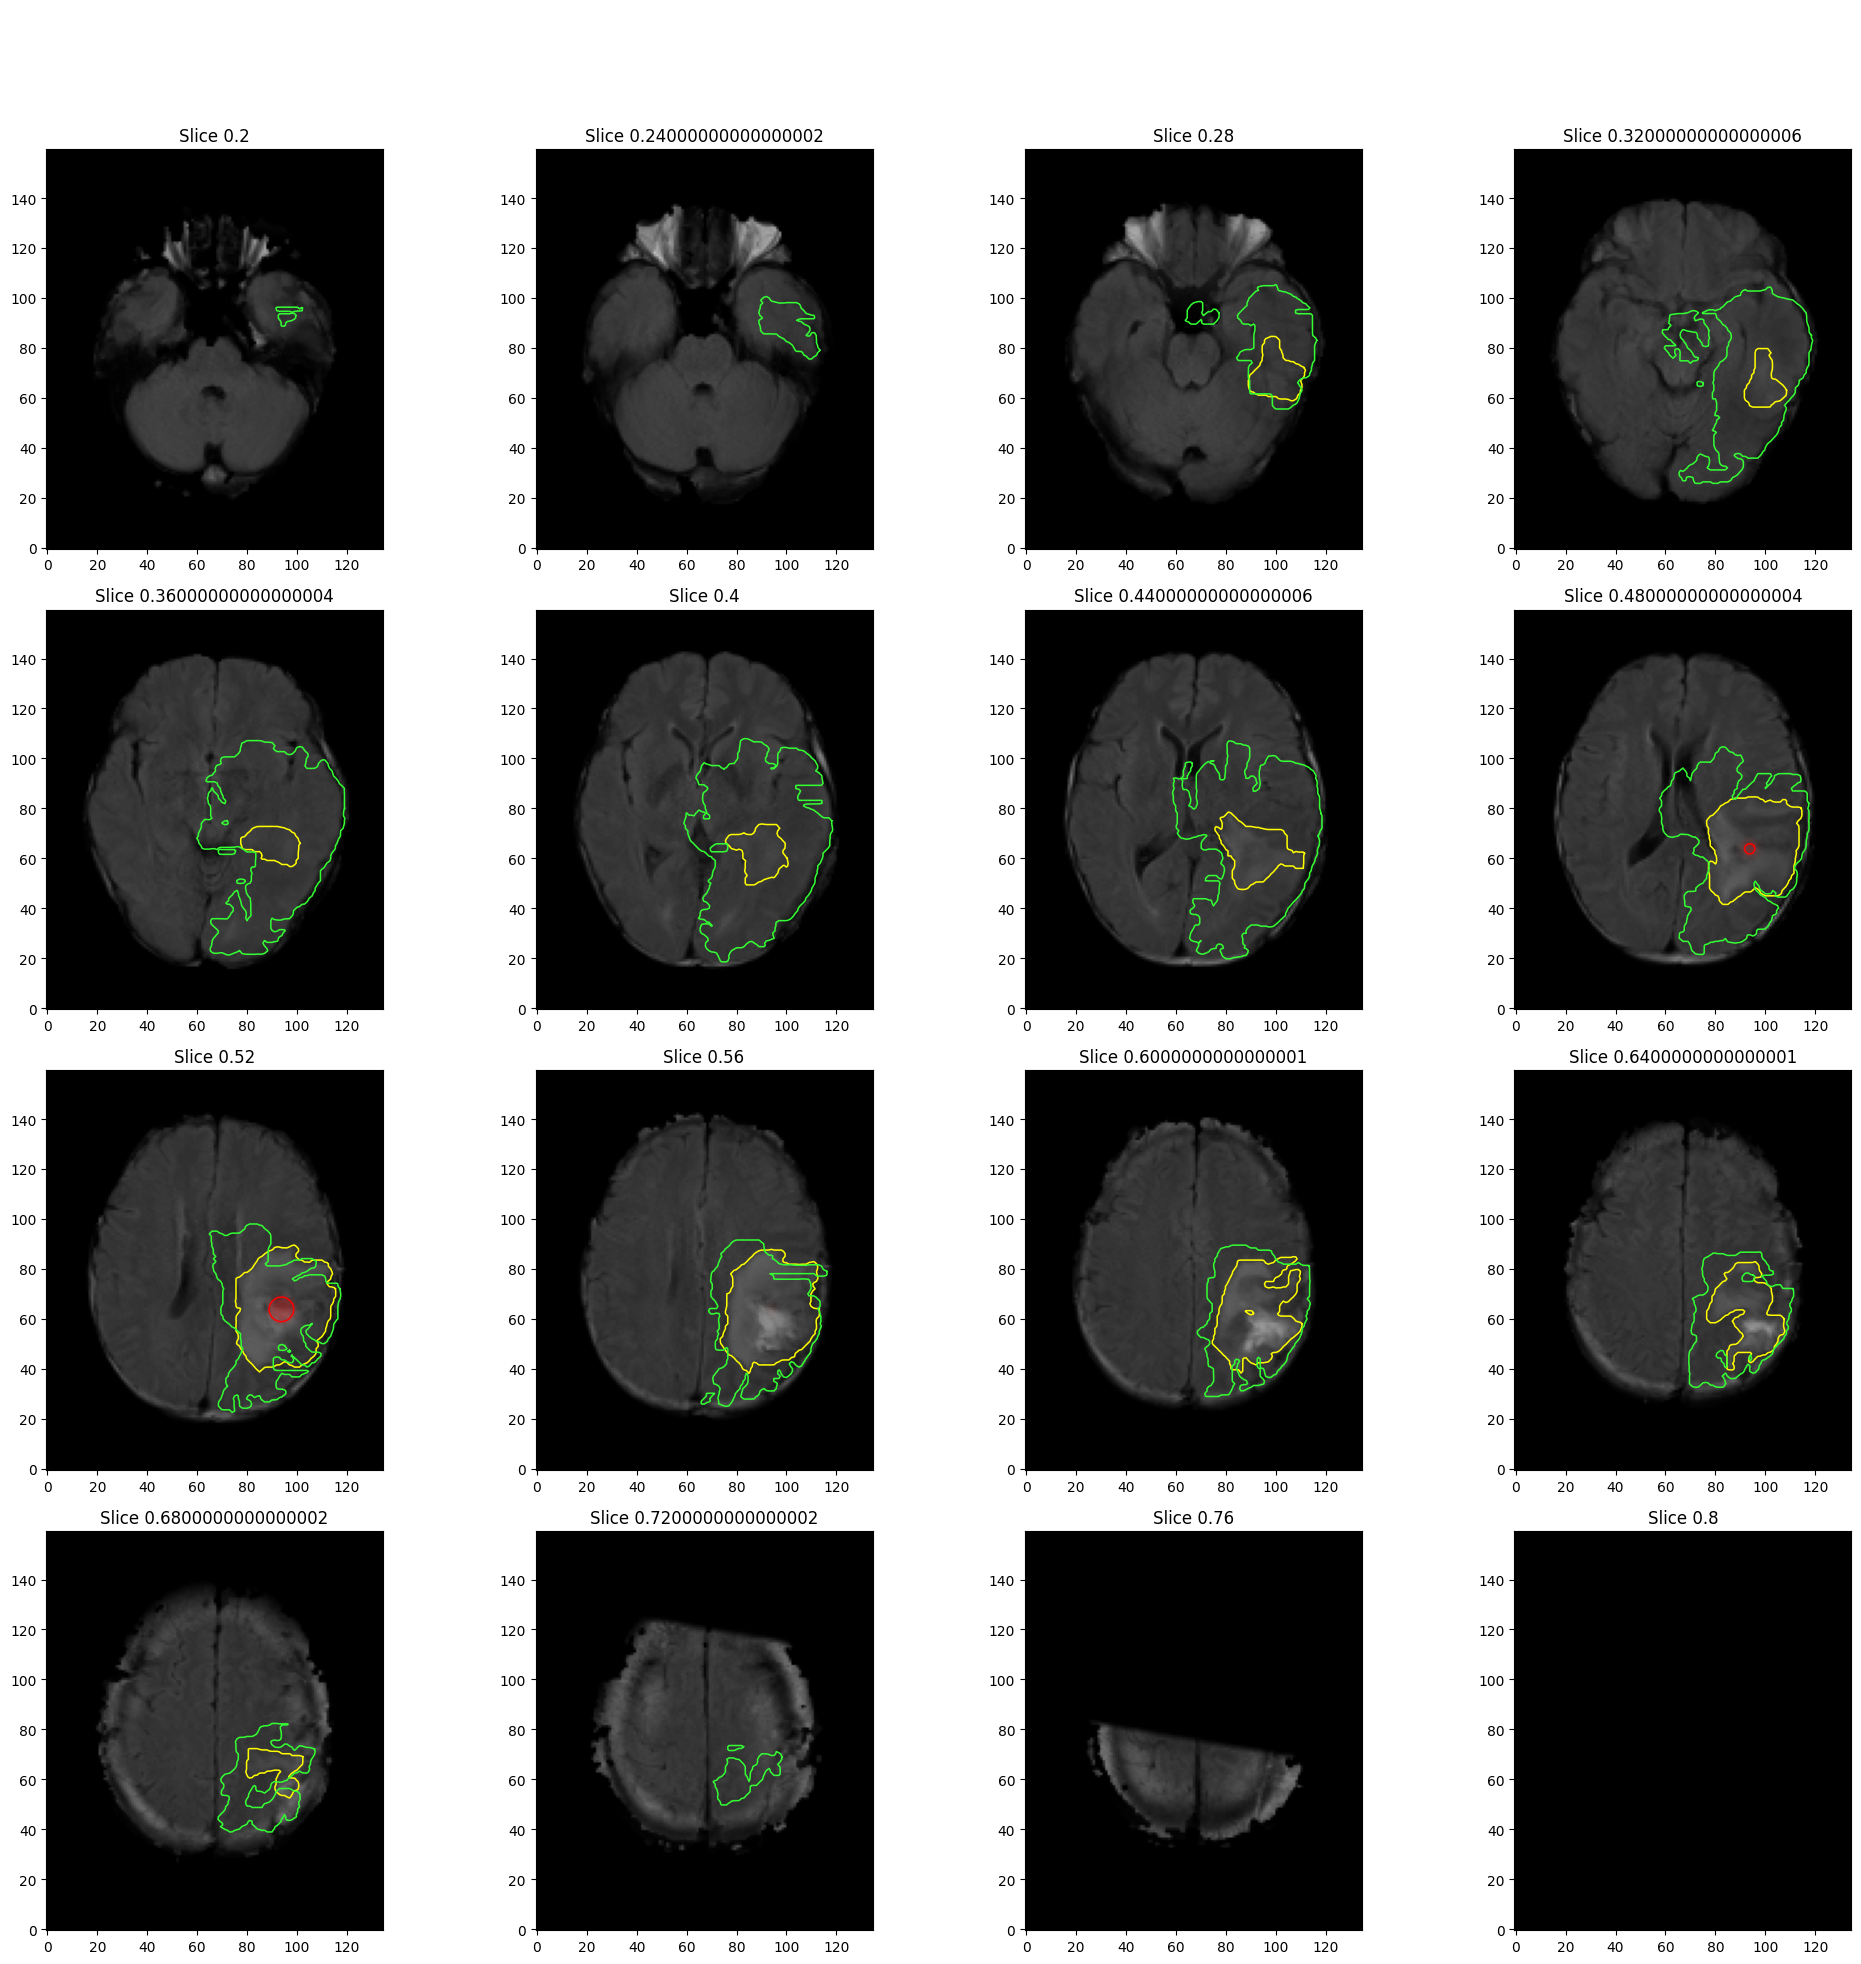

In [290]:
_vis_brain_scan(state.tumor_density.detach().cpu().numpy(),
                [brain_raw / brain_raw.max()], tumor_list, figsize=(5,5), main_title="")

In [267]:
pde.matters[0].max()

tensor(1.0000, device='cuda:0')

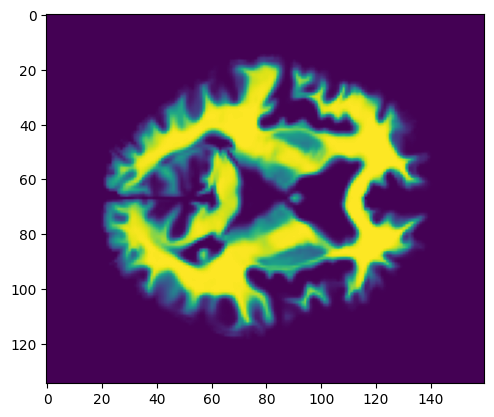

In [ ]:
plt.imshow(pde.matters[1].cpu().numpy()[:,:,60])

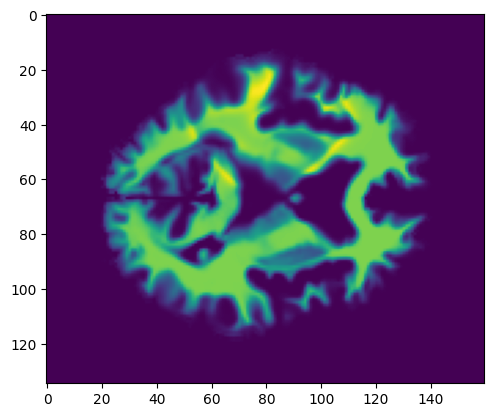

In [ ]:
plt.imshow(state.brain_density[1].cpu().numpy()[:,:,60])

In [156]:
(pde.matters[0] - state.brain_density[0]).max()

tensor(0.5595, device='cuda:0')

In [134]:
state.tumor_density.device

device(type='cpu')